Kaggle Dataset from [https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)

In [1]:
import os
import random
import time
import datetime
import numpy as np
import cv2
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras import optimizers
from keras import backend as K
K.set_image_dim_ordering('th')
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.utils import class_weight
from mlxtend.plotting import plot_confusion_matrix
from datetime import datetime
from IPython.display import display
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

Using TensorFlow backend.
C:\Users\R and L\Anaconda3\Lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\R and L\Anaconda3\Lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\R and L\Anaconda3\Lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\R and L\Anaconda3\Lib\site-packages\tensorflow\python\framework\d

In [4]:
def get_reset_subplot_params(nrows, ncols, dpi):
    subplot_params = {}
    subplot_params["nrows"] = nrows
    subplot_params["ncols"] = ncols

    subplot_params["figsize_col"] = subplot_params["ncols"]*2.5
    subplot_params["figsize_row"] = subplot_params["nrows"]*2.5
    subplot_params["dpi"] = dpi
    subplot_params["facecolor"] = 'w'
    subplot_params["edgecolor"] = 'k'
    subplot_params["subplot_kw"] = {'xticks': [], 'yticks': []}
    subplot_params["axes.titlesize"] = 'small'
    subplot_params["hspace"] = 0.5
    subplot_params["wspace"] = 0.3
    
    return subplot_params

def get_reset_plot_params(figsize=(15, 5), title="", xlabel ="", ylabel="", legends=[], title_fontsize = 18, label_fontsize = 14, image_file_name="", save = False, dpi=100, update_image=True):
    plot_params = {}
    
    plot_params["figsize"] = figsize
    
    plot_params["title"] = title
    
    plot_params["xlabel"] = xlabel
    plot_params["ylabel"] = ylabel
    
    plot_params["legends"] = legends 
    
    plot_params["title_fontsize"] = title_fontsize
    plot_params["axes.titlesize"] = "small"
    plot_params["label_fontsize"] = label_fontsize
    
    plot_params["image_file_name"] = image_file_name
    plot_params["save"] = save
    plot_params["update_image"] = update_image
    
    plot_params["subplot"] = None
    return plot_params
def select_image_by_category(image_dir, image_count_per_category):
    classes = os.listdir(image_dir)
    class_count = len(classes)

    image_file_paths = {}
    
    for i in range(class_count):
        subdir_path = image_dir+"/"+classes[i]
        subdir_files = os.listdir(subdir_path)

        subdir_file_count = len(subdir_files)

        subdir_file_mem = {}
        
        subdir_file_index = -1
        
        image_file_paths[classes[i]] = []
        
        for j in range(image_count_per_category):
            while subdir_file_index in subdir_file_mem:
                subdir_file_index = random.randint(0, subdir_file_count-1)
                
            subdir_file_mem[subdir_file_index] = 1
            
            subdir_file_name = subdir_files[subdir_file_index]
            subdir_file_path = subdir_path+ "/" + subdir_file_name

            image_file_paths[classes[i]].append(subdir_file_path)
            
    return image_file_paths


def get_fig_axs(subplot_params):
    fig, axs = plt.subplots(
        nrows=subplot_params["nrows"], ncols=subplot_params["ncols"], 
        figsize=(subplot_params["figsize_col"], subplot_params["figsize_row"]),
        dpi=subplot_params["dpi"], facecolor=subplot_params["facecolor"], 
        edgecolor=subplot_params["edgecolor"], subplot_kw=subplot_params["subplot_kw"])
        
    return fig, axs
    

def plot_sample_image(image_file_paths, plot_params, subplot_params, update_image=True):
    fig, axs = get_fig_axs(subplot_params)

    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])


    i=0
    for img_filepath in image_file_paths:
        img = cv2.imread(img_filepath, 1)
        plt.title(img_filepath.split("/")[-1])
        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
        plt.imshow(img)
        
        plt.xticks([])
        plt.yticks([])
        
        i=i+1
        
    if plot_params["update_image"] and os.path.exists(plot_params["image_file_name"]):
        os.remove(plot_params["image_file_name"])  
    if plot_params["save"]:
        fig.savefig(plot_params["image_file_name"], dpi=plot_params["dpi"])
        
    plt.tight_layout()
    plt.show()
    
    
def show_class_sample_images(directory, image_count_per_category=5, save=False, dpi=100, update_image=False):
    class_count = len(os.listdir(directory))
    print("Number of Class: ", class_count)
    sample_img_by_class = select_image_by_category(directory, image_count_per_category)
    for class_name in sample_img_by_class:
        plot_params = get_reset_plot_params(image_file_name="img.png", save = save, dpi=dpi, update_image=update_image)
        subplot_params = get_reset_subplot_params(nrows=1, ncols=image_count_per_category, dpi=dpi)
        print("%s%s%s"%("-"*55, class_name, "-"*55))
        plot_sample_image(sample_img_by_class[class_name], plot_params, subplot_params)
        print("")
    print("%s%s%d%s"%("-"*55, "All Class Printed:", class_count, "-"*55))

In [5]:
def dir_file_count(directory):
    return sum([len(files) for r, d, files in os.walk(directory)])

Number of Class:  2
-------------------------------------------------------NORMAL-------------------------------------------------------


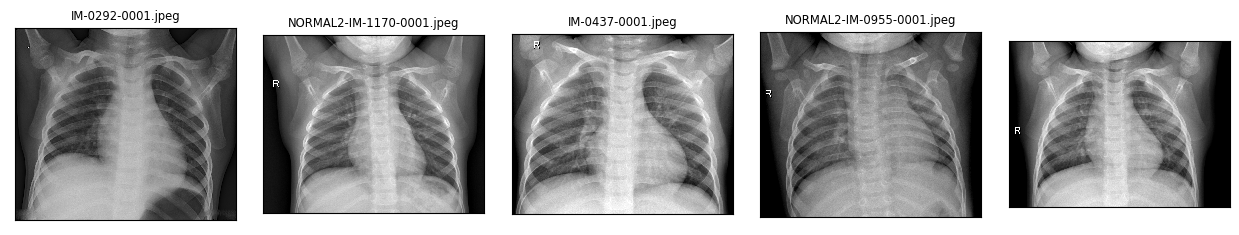


-------------------------------------------------------PNEUMONIA-------------------------------------------------------


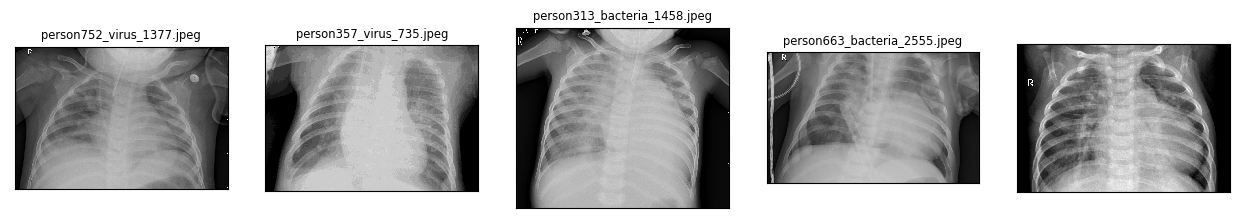


-------------------------------------------------------All Class Printed:2-------------------------------------------------------


In [6]:
training_dir=r'C:\Users\R and L\Downloads\chest_xray\train'
validation_dir=r'C:\Users\R and L\Downloads\chest_xray\val'
testing_dir=r'C:\Users\R and L\Downloads\chest_xray\test'
output_directory=r'C:\Users\R and L\Downloads'
show_class_sample_images(training_dir, image_count_per_category=5, save=False, dpi=100, update_image=False)

In [7]:
# batch_size = 32

# target_size = (299, 299)
# color_mode = "rgb"


rescale = 1./255
target_size = (150, 150)
batch_size = 163
class_mode = "categorical"
# class_mode = "binary"


train_datagen = ImageDataGenerator(
    rescale=rescale,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=True)


validation_datagen = ImageDataGenerator(rescale=rescale)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=dir_file_count(validation_dir),
    shuffle = False)


test_datagen = ImageDataGenerator(rescale=rescale)

test_generator = test_datagen.flow_from_directory(
    testing_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=dir_file_count(testing_dir),
    shuffle = False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:
class_weight = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)
class_weight

main_model_dir = output_directory + "\\models\\"
main_log_dir = output_directory + "\\logs\\"

model_dir = main_model_dir + time.strftime('%Y-%m-%d %H-%M-%S') + "\\"
log_dir = main_log_dir + time.strftime('%Y-%m-%d %H-%M-%S')

os.makedirs(model_dir)
os.makedirs(log_dir)

model_file = model_dir + "{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(
    model_file, 
    monitor='val_acc', 
    save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True)


tensorboard = TensorBoard(
    log_dir=log_dir,
    batch_size=batch_size,
    update_freq = 'batch')


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    cooldown=2,
    min_lr=0.0000000001,
    verbose=1)


#-----------------------------------------------------------------------------------------------------------------#
callbacks = [checkpoint, reduce_lr, early_stopping, tensorboard]
# callbacks = [checkpoint, tensorboard]
#-----------------------------------------------------------------------------------------------------------------#


In [7]:
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(3,150,150)))
    model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(3,150,150)))
    model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
    model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
    model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2 , activation='softmax'))


    print(model.summary())
    
    return model

In [8]:
model = get_conv_model()

W0922 23:43:13.275191 12220 deprecation_wrapper.py:119] From C:\Users\R and L\Anaconda3\Lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0922 23:43:13.278194 12220 deprecation_wrapper.py:119] From C:\Users\R and L\Anaconda3\Lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0922 23:43:13.282198 12220 deprecation_wrapper.py:119] From C:\Users\R and L\Anaconda3\Lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0922 23:43:13.298212 12220 deprecation_wrapper.py:119] From C:\Users\R and L\Anaconda3\Lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0922 23:43:13.299212 12220 deprecation_wrapper.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 150, 150)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 150, 150)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 75, 75)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 75, 75)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 75, 75)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 37, 37)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 37, 37)        18496     
__________

In [9]:
print("Starting Trainning Model", datetime.now().strftime('%Y%m%d %H:%M:%S'))

steps_per_epoch=len(train_generator)
validation_steps=len(validation_generator)


# lr = 0.00001
# optimizer=optimizers.Adam(lr=lr)


optimizer=optimizers.Adam()
loss='categorical_crossentropy'
metrics=['accuracy']
epochs = 100


model.compile(optimizer, loss=loss, metrics=metrics)

history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs=epochs,
    verbose=2,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=validation_steps, 
    class_weight=class_weight)

print("Completed Model Trainning", datetime.now().strftime('%Y%m%d %H:%M:%S'))

Starting Trainning Model 20190922 23:43:13


W0922 23:43:13.660185 12220 deprecation_wrapper.py:119] From C:\Users\R and L\Anaconda3\Lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0922 23:43:13.783525 12220 deprecation.py:323] From C:\Users\R and L\Anaconda3\Lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0922 23:43:14.835565 12220 deprecation_wrapper.py:119] From C:\Users\R and L\Anaconda3\Lib\site-packages\keras\callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0922 23:43:14.837253 12220 deprecation_wrapper.py:119] From C:\Users\R and L\Anaconda3\Lib\site-packages\keras\callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please u

Epoch 1/100
 - 173s - loss: 0.6028 - acc: 0.7224 - val_loss: 0.7952 - val_acc: 0.5000
Epoch 2/100
 - 163s - loss: 0.5632 - acc: 0.7429 - val_loss: 0.7470 - val_acc: 0.5000
Epoch 3/100
 - 164s - loss: 0.5799 - acc: 0.7429 - val_loss: 0.7699 - val_acc: 0.5000
Epoch 4/100
 - 164s - loss: 0.5711 - acc: 0.7429 - val_loss: 0.8541 - val_acc: 0.5000
Epoch 5/100
 - 169s - loss: 0.4399 - acc: 0.7885 - val_loss: 0.6246 - val_acc: 0.6875
Epoch 6/100
 - 168s - loss: 0.3257 - acc: 0.8558 - val_loss: 0.5961 - val_acc: 0.7500
Epoch 7/100
 - 168s - loss: 0.2815 - acc: 0.8844 - val_loss: 0.5044 - val_acc: 0.8750
Epoch 8/100
 - 168s - loss: 0.2546 - acc: 0.9032 - val_loss: 0.5203 - val_acc: 0.7500
Epoch 9/100
 - 160s - loss: 0.2060 - acc: 0.9216 - val_loss: 0.7334 - val_acc: 0.5000
Epoch 10/100
 - 161s - loss: 0.1977 - acc: 0.9241 - val_loss: 0.8033 - val_acc: 0.6250
Epoch 11/100
 - 156s - loss: 0.1671 - acc: 0.9404 - val_loss: 0.5782 - val_acc: 0.6250
Epoch 12/100
 - 158s - loss: 0.1684 - acc: 0.9381 - 

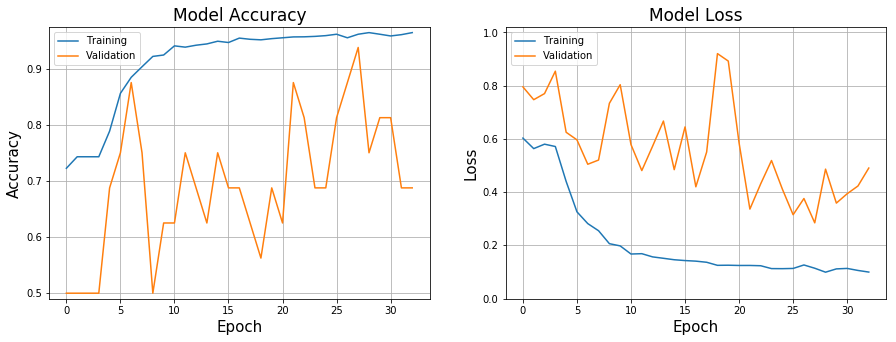

In [10]:
xlabel = 'Epoch'
legends = ['Training', 'Validation']

ylim_pad = [0.01, 0.1]


plt.figure(figsize=(15, 5))

# Plot training & validation Accuracy values

y1 = history.history['acc']
y2 = history.history['val_acc']

min_y = min(min(y1), min(y2))-ylim_pad[0]
max_y = max(max(y1), max(y2))+ylim_pad[0]


plt.subplot(121)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Accuracy', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()

                         
# Plot training & validation loss values
    
y1 = history.history['loss']
y2 = history.history['val_loss']

min_y = min(min(y1), min(y2))-ylim_pad[1]
max_y = max(max(y1), max(y2))+ylim_pad[1]
    
    
plt.subplot(122)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Loss', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()
                         
plt.show()

In [11]:
os.listdir(r'C:\Users\R and L\Downloads\models\2019-09-22 23-43-12')

['01-val_acc-0.50-val_loss-0.80.hdf5',
 '05-val_acc-0.69-val_loss-0.62.hdf5',
 '06-val_acc-0.75-val_loss-0.60.hdf5',
 '07-val_acc-0.88-val_loss-0.50.hdf5',
 '28-val_acc-0.94-val_loss-0.28.hdf5']

In [2]:
model_file=r'C:\Users\R and L\Downloads\models\2019-09-22 23-43-12\28-val_acc-0.94-val_loss-0.28.hdf5'
model = keras.models.load_model(model_file)

W0923 09:31:35.676746 16668 deprecation_wrapper.py:119] From C:\Users\R and L\Anaconda3\Lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0923 09:31:35.698765 16668 deprecation_wrapper.py:119] From C:\Users\R and L\Anaconda3\Lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0923 09:31:35.706772 16668 deprecation_wrapper.py:119] From C:\Users\R and L\Anaconda3\Lib\site-packages\keras\backend\tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0923 09:31:35.707774 16668 deprecation_wrapper.py:119] From C:\Users\R and L\Anaconda3\Lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0923 09:31:35.707774 16668 deprecation_wrapper

In [8]:
print("results")
result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

results
1/1 [==============================] - 13s 13s/step
Loss     : 0.27  
Accuracy : 91.67%


In [9]:
print("results")
y_pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)  
y_pred = y_pred.argmax(axis=-1)
y_true=test_generator.classes

results
1/1 [==============================] - 13s 13s/step


In [19]:
image_file_name_batch = output_directory+r"\result"
image_file_name_sample = output_directory+r"\sample"
image_file_name_CM = output_directory+"\CM"

------------------------------------------------------------------------------------------
Derived Report
------------------------------------------------------------------------------------------
Precision     : 91.22%
Recall        : 95.90%
F1-Score      : 93.50%
------------------------------------------------------------------------------------------





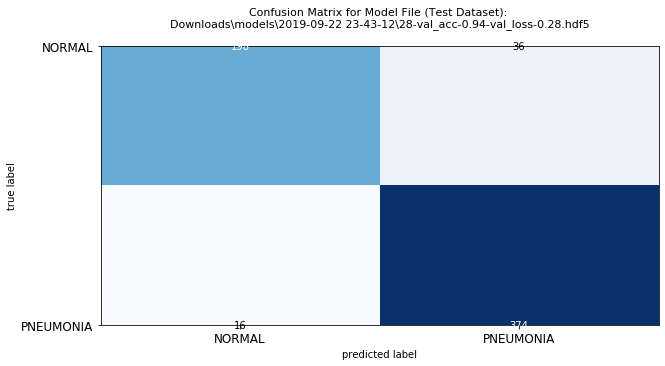




------------------------------------------------------------------------------------------
Report for Model File:  Downloads\models\2019-09-22 23-43-12\28-val_acc-0.94-val_loss-0.28.hdf5
------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

      NORMAL       0.93      0.85      0.88       234
   PNEUMONIA       0.91      0.96      0.94       390

    accuracy                           0.92       624
   macro avg       0.92      0.90      0.91       624
weighted avg       0.92      0.92      0.92       624

------------------------------------------------------------------------------------------


In [20]:
classes = os.listdir(training_dir)

title = model_file.split("\\")
model_title = "\\".join([i for i in title[3:]])

precision = precision_score(y_true, y_pred) 
recall = recall_score(y_true, y_pred) 
f1 = f1_score(y_true, y_pred) 

print("-"*90)
print("Derived Report")
print("-"*90)
print("%s%.2f%s"% ("Precision     : ", precision*100, "%"))
print("%s%.2f%s"% ("Recall        : ", recall*100,    "%"))
print("%s%.2f%s"% ("F1-Score      : ", f1*100,        "%"))
print("-"*90)
print("\n\n")

CM = confusion_matrix(y_true, y_pred)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(10,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(len(classes)), classes, fontsize=12)
plt.yticks(range(len(classes)), classes, fontsize=12)
plt.title("Confusion Matrix for Model File (Test Dataset): \n"+model_title, fontsize=11)
fig.savefig(image_file_name_CM, dpi=100)
plt.show()
    

cls_report_print = classification_report(y_true, y_pred, target_names=classes)

cls_report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)

print("\n\n")
print("-"*90)
print("Report for Model File: ", model_title)
print("-"*90)
print(cls_report_print)
print("-"*90)

In [21]:
numofbatch = len(test_generator)

batch_no = random.randint(0, numofbatch-1)

y_img_batch, y_true_batch = test_generator[batch_no] 
y_true_batch = y_true_batch.argmax(axis=-1)

y_pred_batch = model.predict(y_img_batch)
y_pred_batch = y_pred_batch.argmax(axis=-1)


sizeofbatch = len(y_true_batch)
print("-"*35)
print("%s%d"%     ("Selected Batch No       : ", batch_no))
print("-"*35)
print("%s%d"%     ("Batch Size              : ", len(y_pred_batch)))
print("-"*35)
print("%s%.2f%s"% ("Accuracy                : ", np.mean(y_true==y_pred)*100, "%"))

-----------------------------------
Selected Batch No       : 0
-----------------------------------
Batch Size              : 624
-----------------------------------
Accuracy                : 91.67%


In [22]:
def show_predictions(y_img_batch, y_true, y_pred, subplot_params, plot_params, class_map, testing_dir, image_file_name, count=8, sample=True):
    fig, axs = get_fig_axs(subplot_params)
    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])
    
    file_names = test_generator.filenames
    m = {}
    length = len(y_true)
    for i in range(0, count): 
        num = i
        if sample:
            num = random.randint(0, length-1)
            while num in m:
                num = int(random.randint(0, length-1))

            m[num]=1


        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
        img = cv2.imread(testing_dir+"\\"+ file_names[num], 1)
        plt.imshow(img)

        plt.xticks([])
        plt.yticks([])
        
        
        original = class_map[y_true[num]]
        predicted = class_map[y_pred[num]]
        
        
        title_text = ("%s%s%s%s%s"%("True: ", original, "\n", "Pred: ", predicted))
        
        if original==predicted:
            plt.title(title_text)
        else:
            plt.title(title_text, color='red')
            

        if plot_params["update_image"] and os.path.exists(image_file_name):
            os.remove(image_file_name)   

        fig.savefig(image_file_name, dpi=subplot_params["dpi"])

    plt.tight_layout()
    plt.show()

In [23]:
batch_size_t = len(y_true_batch)

class_map = {v: k for k, v in test_generator.class_indices.items()}


dpi=100


ncols = 8
# ncols = batch_size_t if batch_size_t<ncols else ncols     
# nrows = batch_size_t/ncols
# nrows = int(batch_size_t/ncols)+1 if batch_size_t%ncols else  int(batch_size_t/ncols)
nrows = 4

count = ncols*nrows


subplot_params = get_reset_subplot_params(nrows, ncols, dpi)
plot_params = get_reset_plot_params()

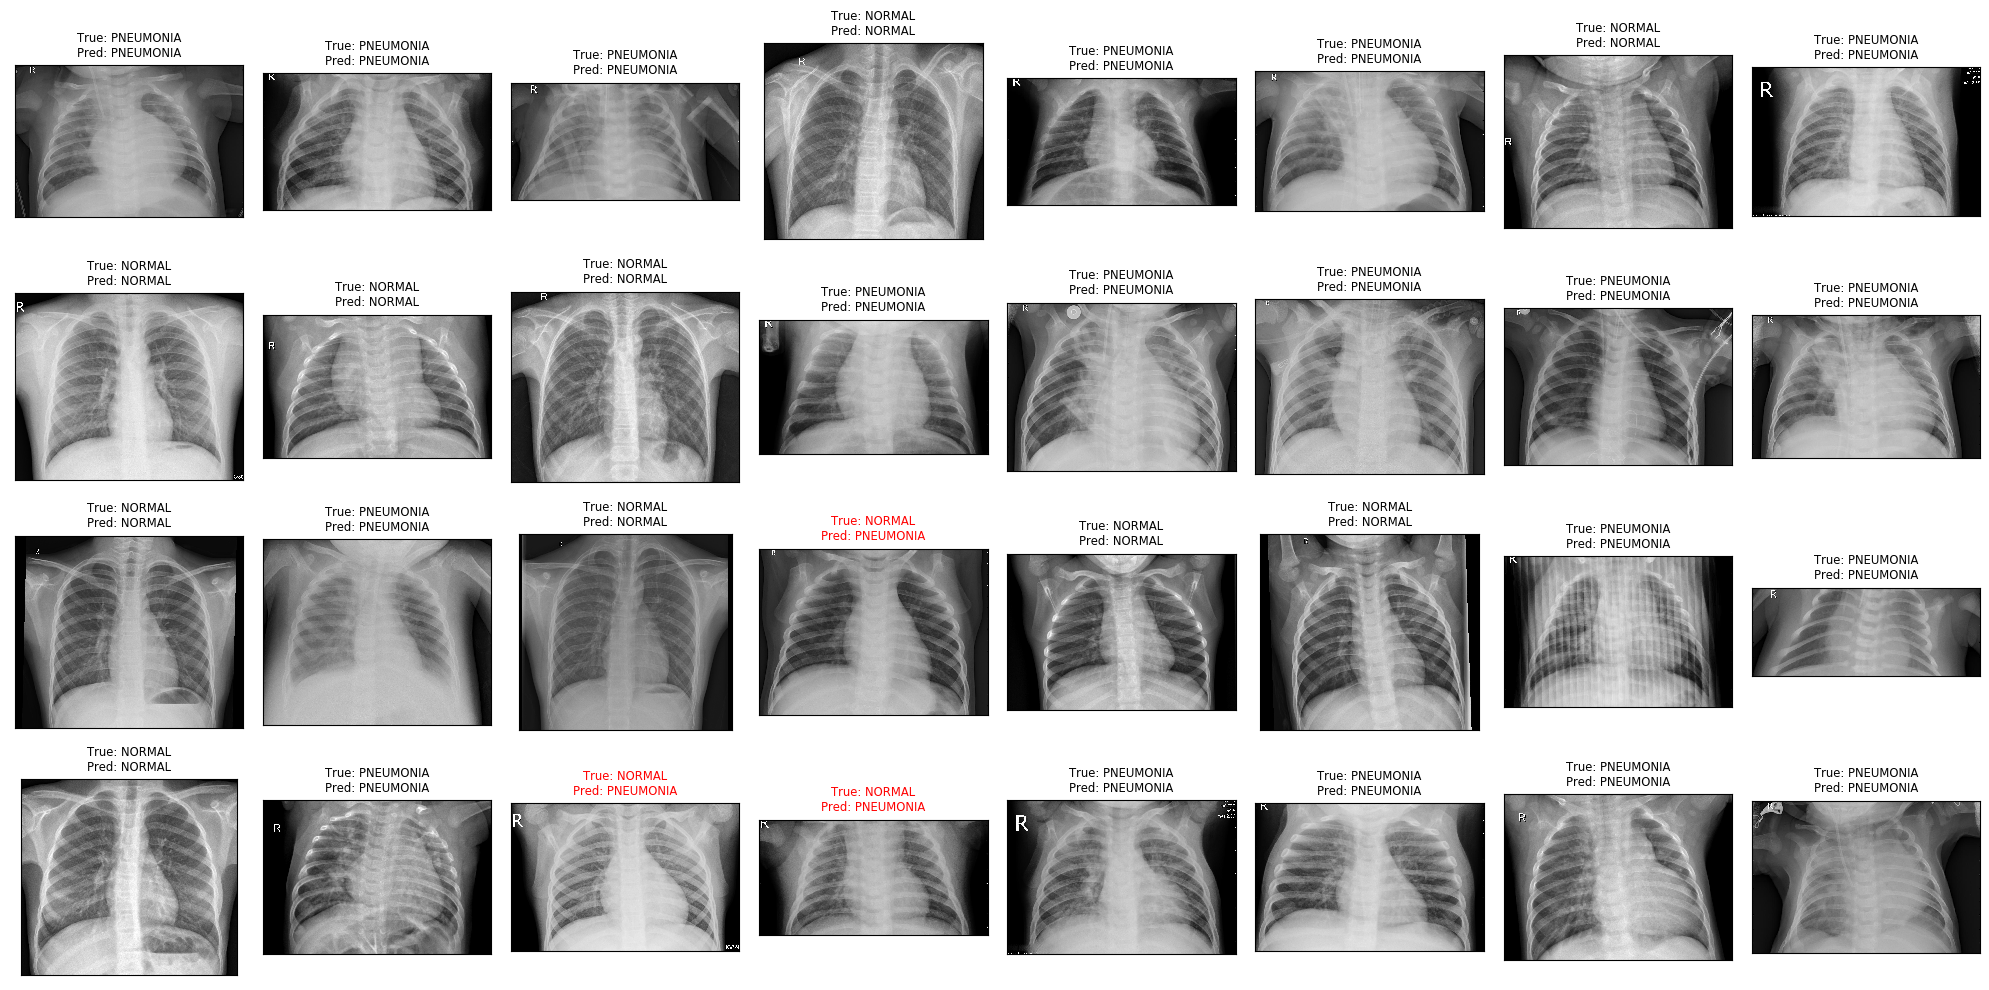

In [17]:
show_predictions(y_img_batch, y_true_batch, y_pred_batch, subplot_params, plot_params, class_map, testing_dir, image_file_name_batch, count=count, sample=True)

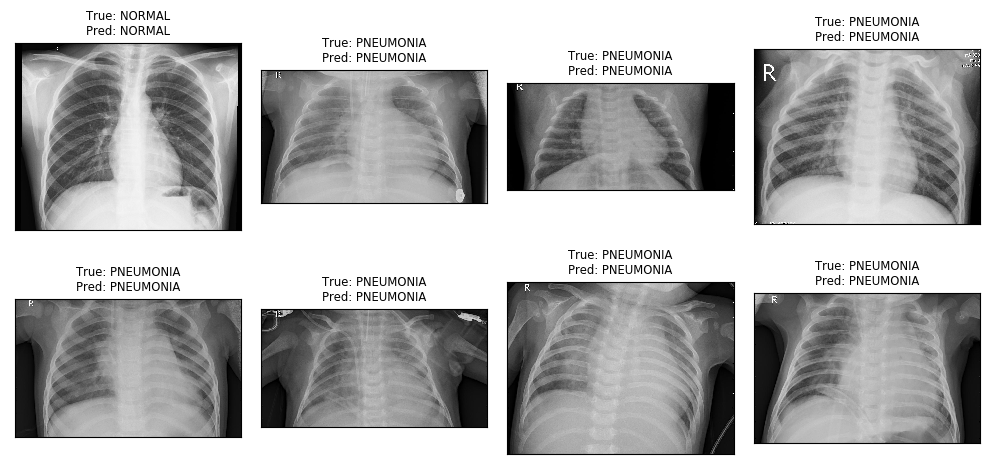

In [24]:
ncols = 4
nrows = 2

if batch_size_t<4:
    ncols = 1
    
count = ncols*nrows
    

subplot_params = get_reset_subplot_params(nrows, ncols, dpi)
plot_params = get_reset_plot_params()


show_predictions(y_img_batch, y_true_batch, y_pred_batch, subplot_params, plot_params, class_map, testing_dir, image_file_name_sample, count=count, sample=True)